# QCArchive+QCMLForge Demo with CyberShuttle

The first half of this demo shows how to use QCArchive to setup a dataset
and run computations with ease. The compute resource for this noteboook
uses Cybershuttle; however, a purely local resource demo is available under
`./demo_local.ipynb`.

The second half of this demo shows how one can consume the generated data
to train AP-Net models through QCMLForge. 

## How is this useful?
Prior to using quantum mechanical (QM) methods for applications, often computational
chemists will either consult previous studies of benchmarked methods on similar
systems, or perform the benchmarking task themselves. Then after quantifying
error, the level of theory that balances both expected error and is a reasonable
computational cost will be selected for applying to novel system(s).

The Sherrill research group has performed quite a few of these benchmarking
studies particularly for studying intermolecular interaction energies. These
interaction energies basically determine how attractive (or repulsive) molecules
behave when brought close together. A more practical definition for an
interaction energy (IE) is: 

$E_{\rm IE} = E_{\rm dimer} - E_{\rm monomerA} - E_{\rm monomerB}$.

Hence, the interaction energy is defined as the energy difference between
the dimer (when the two molecules are together) and the molecules on
their own (monomerA and monomerB in isolation).

To demonstrate how one might carryout the computational aspects of a
benchmarking study, the present notebook will provide examples of managing
datasets with QCArchive and running QM calculations prior to analyzing error
statistics with respect to reference energies. The second half of the notebook
provides examples on how you could then apply QM data towards training ML models
through QCMLForge.

In [1]:
import psi4
from pprint import pprint as pp
import pandas as pd
import numpy as np
from qm_tools_aw import tools
import matplotlib.pyplot as plt
# QCElemental Imports
from qcelemental.models import Molecule
import qcelemental as qcel
# Dataset Imports
from qcportal import PortalClient
from qcportal.singlepoint import SinglepointDatasetEntry, QCSpecification
from qcportal.manybody import ManybodyDatasetEntry, ManybodySpecification
from torch import manual_seed

manual_seed(42)

h2kcalmol = qcel.constants.hartree2kcalmol
print('Imports')

Imports


# QCArchive Setup
QCArchive uses a PostgreSQL database for storing QM data including geometries,
energies, and properties. Furthermore, to save on compute resources, every job
generates a unique hash allowing future computations to be able to query previous
job results for avoiding re-computing calculations, unless specifically requested.

The following function initializes the QCArchive DB and QCFractal server, allowing
us to then start the services for interfacing them through python. The configurations
below will operate on a remote node through cybershuttle.

In [14]:
from qcmlforge import qca
import os

# Update these if you request non-default resources from cybershuttle.yml
max_workers = 2
cores_per_worker = 8
memory_per_worker = 16

qca.setup_qcarchive_qcfractal(
    QCF_BASE_FOLDER=os.path.join(os.getcwd(), "qcfractal"),
    start=False,
    reset=False,
    db_config={
        "name": None,
        "enable_security": "false",
        "allow_unauthenticated_read": None,
        "logfile": None,
        "loglevel": None,
        "service_frequency": 5,
        "max_active_services": None,
        "heartbeat_frequency": 60,
        "log_access": None,
        "database": {
            "base_folder": None,
            "host": None,
            "port": 5433,
            "database_name": "qca",
            "username": None,
            "password": None,
            "own": None,
        },
        "api": {
            "host": None,
            "port": 7778,
            "secret_key": None,
            "jwt_secret_key": None,
        },
    },
    resources_config={
            "update_frequency": 5,
            "cores_per_worker": cores_per_worker,
            "max_workers": max_workers,
            "memory_per_worker": memory_per_worker,
    },
    conda_env=None,
    worker_sh=None,
)

/home/amwalla3/gits/cybershuttle_demo/qcfractal
/home/amwalla3/gits/cybershuttle_demo/qcfractal/postgres

--------------------------------------------------------------------------------
Python executable:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/python
QCFractal version:  0.59
QCFractal alembic revision:  d5988aa750ae
pg_ctl path:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/pg_ctl
PostgreSQL server version:  PostgreSQL 17.4 on x86_64-conda-linux-gnu, compiled by x86_64-conda-linux-gnu-cc (conda-forge gcc 13.3.0-2) 13.3.0, 64-bit
--------------------------------------------------------------------------------


Displaying QCFractal configuration below
--------------------------------------------------------------------------------
access_log_keep: 0
allow_unauthenticated_read: true
api:
  extra_flask_options: null
  extra_waitress_options: null
  host: localhost
  jwt_access_token_expires: 3600
  jwt_refresh_token_expires: 86400
  jwt_secret_key: M7u-bxfJMAopCfzJNXjIW9HFHd4R3Txgn_iN

In [15]:
get_ipython().system = os.system
!qcfractal-server --config=`pwd`/qcfractal/qcfractal_config.yaml start > qcfractal/qcf_server.log &

0

In [16]:
!qcfractal-compute-manager --config=`pwd`/qcfractal/resources.yml &

0

[2025-05-07 08:45:58 EDT]     INFO: qcfractalcompute.config: Reading configuration data from /home/amwalla3/gits/cybershuttle_demo/qcfractal/resources.yml
**********
Logging to file /home/amwalla3/gits/cybershuttle_demo/qcfractal/qcfractal-manager.log, logging level INFO
**********


In [2]:
# Establish client connection
client = PortalClient("http://localhost:7778", verify=False)
print(client)

PortalClient(server_name='QCFractal Server', address='http://localhost:7778/', username='None')


# QCArchive single point example with Psi4

QCArchive/QCFractal can be used to run several QM softwares, but the focus of
the present notebook will highlight the popular, open-source Psi4 program. 

As a simple example, we can specify a water dimer geometry and then
create a singlepoint energy entry into the database with the client.

In [3]:
# Running a single job
mol = Molecule.from_data(
    """
     0 1
     O  -1.551007  -0.114520   0.000000
     H  -1.934259   0.762503   0.000000
     H  -0.599677   0.040712   0.000000
     --
     0 1
     O   1.350625   0.111469   0.000000
     H   1.680398  -0.373741  -0.758561
     H   1.680398  -0.373741   0.758561

     units angstrom
     no_reorient
     symmetry c1
"""
)

client.add_singlepoints(
    [mol],
    "psi4",
    driver="energy",
    method="b3lyp",
    basis="aug-cc-pvdz",
    keywords={"scf_type": "df", "e_convergence": 6, "freeze_core": True},
    tag="local",
)


(InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0]),
 [1])

## Query Results

In [4]:
recs = client.query_records(
    record_id=[1]
)
print(recs)
for rec in recs:
    print(rec.status)
    print(rec)
    print(rec.dict)
    print(rec.properties['return_result'])

RecordStatusEnum.complete
<SinglepointRecord id=1 status=complete>
<bound method BaseModel.dict of SinglepointRecord(id=1, record_type='singlepoint', is_service=False, properties={'pe energy': 0.0, 'scf dipole': [1.014433761214748, 0.03039716795360614, 4.741514255876544e-12], 'calcinfo_nmo': 82, 'dft xc energy': -15.093933325834762, 'return_energy': -152.89658734330817, 'return_result': -152.89658734330817, 'scf_xc_energy': -15.093933325834762, 'calcinfo_natom': 6, 'calcinfo_nbeta': 10, 'current dipole': [1.014433761214748, 0.03039716795360614, 4.741514255876544e-12], 'current energy': -152.89658734330817, 'return_hessian': None, 'scf_iterations': 8, 'calcinfo_nalpha': 10, 'calcinfo_nbasis': 82, 'dft vv10 energy': 0.0, 'return_gradient': None, 'dft total energy': -152.89658734330817, 'scf_total_energy': -152.89658734330817, 'scf_dipole_moment': [1.014433761214748, 0.03039716795360614, 4.741514255876544e-12], 'scf_total_hessian': None, 'scf total energies': [-152.18329179022413, -152.54

# Dataset Example
While one could use the above logic for all calculations, QCArchive provides
dataset options to make managing data for a specific application substantially
easier. 

Prior to creating the QCArchive datasets, we will first load in data from a 
recently submitted Sherrill work [Levels of SAPT II](https://chemrxiv.org/engage/chemrxiv/article-details/67fe885f6e70d6fb2e033804). To faciliate insertion
into the DB, we will create QCElemental Molecule objects in the pickle file
and extract specific columns to store as variables for usage below. 

In [5]:
# Creating a QCArchive Dataset...
# Load in a dataset from a recent Sherrill work (Levels of SAPT II)
df_LoS = pd.read_pickle("./combined_df_subset_358.pkl")
print(df_LoS[['Benchmark', 'SAPT2+3(CCD)DMP2 TOTAL ENERGY aqz', 'MP2 IE atz', 'SAPT0 TOTAL ENERGY adz' ]])

# Limit to 100 molecules with maximum of 16 atoms to keep computational cost down
df_LoS['size'] = df_LoS['atomic_numbers'].apply(lambda x: len(x))
df_LoS = df_LoS[df_LoS['size'] <= 16]
df_LoS = df_LoS.sample(100, random_state=42, axis=0).copy()
# df_LoS = df_LoS.sample(50, random_state=42, axis=0).copy()
df_LoS.reset_index(drop=True, inplace=True)
print(df_LoS['size'].describe())

# Create QCElemntal Molecules to generate the dataset
def qcel_mols(row):
    """
    Convert the row to a qcel molecule
    """
    atomic_numbers = [row['atomic_numbers'][row['monAs']], row['atomic_numbers'][row['monBs']]]
    coords = [row['coordinates'][row['monAs']], row['coordinates'][row['monBs']]]
    cm = [
        [row['monA_charge'], row['monA_multiplicity']],
        [row['monB_charge'], row['monB_multiplicity']],
     ]
    return tools.convert_pos_carts_to_mol(atomic_numbers, coords, cm)
df_LoS['qcel_molecule'] = df_LoS.apply(qcel_mols, axis=1)
geoms = df_LoS['qcel_molecule'].tolist()
ref_IEs = df_LoS['Benchmark'].tolist()
sapt0_adz = (df_LoS['SAPT0 TOTAL ENERGY adz'] * h2kcalmol).tolist()

     Benchmark SAPT2+3(CCD)DMP2 TOTAL ENERGY aqz  MP2 IE atz  \
0      -10.248                         -0.016681   -0.015629   
1      -15.245                         -0.024763   -0.023012   
2       -3.517                         -0.005637   -0.005608   
3       -0.127                         -0.000187   -0.000194   
4       -8.990                         -0.014655   -0.013687   
..         ...                               ...         ...   
353     -4.390                         -0.007196   -0.006835   
354     -1.130                         -0.001489   -0.002395   
355     -0.260                         -0.000432   -0.000450   
356     -5.740                         -0.009198   -0.008974   
357     -3.120                         -0.004909   -0.005518   

     SAPT0 TOTAL ENERGY adz  
0                 -0.018254  
1                 -0.027620  
2                 -0.005920  
3                 -0.000192  
4                 -0.016209  
..                      ...  
353               -0.

## Singlepoint Dataset

First, to demonstrate how you could use this data for singlepoint energies/properties like the water
dimer example above, we will create a singlepoint dataset and slot in our geometry data. 

In [6]:
# Create client dataset
ds_name = 'LoS-singlepoint'
client_datasets = [i['dataset_name'] for i in client.list_datasets()]
# Check if dataset already exists, if not create a new one
if ds_name not in client_datasets:
    ds = client.add_dataset("singlepoint", ds_name,
                            f"Dataset to contain {ds_name}")
    print(f"Added {ds_name} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        extras = {
            "name": 'LoS-' + str(idx),
            "idx": idx,
        }
        mol = Molecule.from_data(mol.dict(), extras=extras)
        ent = SinglepointDatasetEntry(name=extras['name'], molecule=mol)
        entry_list.append(ent)
    ds.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
else:
    ds = client.get_dataset("singlepoint", ds_name)
    print(f"Found {ds_name} dataset, using this instead")

print(ds)

Found LoS-singlepoint dataset, using this instead
id=1 dataset_type='singlepoint' name='LoS-singlepoint' description='Dataset to contain LoS-singlepoint' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [7]:
# Can delete the dataset if you want to start over. Need to know dataset_id
# client.delete_dataset(dataset_id=ds.id, delete_records=True)

# Create QCSpecification and submit computations
Now that the dataset has been created with our molecular systems, we will
specify a level of theory (method/basis set) for running our calculations. We
will name our specification "psi4/SAPT0/cc-pvdz" to easily label this
specification's level of theory and program. This name will be used later
during data collection and analysis. Although many QM methods that use a
singlepoint energy would return a total energy, SAPT is a specialized method
that directly computes the interaction energy between our monomers.

In [8]:
# SAPT0 Example
method, basis = "SAPT0", "cc-pvdz"

# Set the QCSpecification (QM interaction energy in our case)
spec = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "scf_type": "df",
    },
)
ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0])

In [9]:
# Run the computations
ds.submit()
print(f"Submitted {ds_name} dataset")

Submitted LoS-singlepoint dataset


In [10]:
# Check the status of the dataset - can repeatedly run this to see the progress
ds.status()

{'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 100}}

## Manybody Dataset - typical way to compute interaction energies with most QM methods

While SAPT0 returns an interaction energy from a singlepoint energy, most other QM
methods like HF, MP2, CCSD, or DFT would return a total dimer energy ($E_{\rm dimer}$). To
get QCArchive to run the energies of the dimer, monomerA, and monomerB and return the 
energy difference as above for $E_{\rm IE}$, we can use the ManybodyDataset. The setup is
similar to the singlepoint dataset above, but using different objects.

In [11]:
# Create client dataset
ds_name_mb = 'LoS-manybody'
client_datasets = [i['dataset_name'] for i in client.list_datasets()]
# Check if dataset already exists, if not create a new one
if ds_name_mb not in client_datasets:
    print("Setting up new dataset:", ds_name_mb)
    ds_mb = client.add_dataset("manybody", ds_name_mb,
                            f"Dataset to contain {ds_name_mb}")
    print(f"Added {ds_name_mb} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        ent = ManybodyDatasetEntry(name=f"LoS-IE-{idx}", initial_molecule=mol)
        entry_list.append(ent)
    ds_mb.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
else:
    ds_mb = client.get_dataset("manybody", ds_name_mb)
    print(f"Found {ds_name_mb} dataset, using this instead")

print(ds_mb)

# Can delete the dataset if you want to start over. Need to know dataset_id
# client.delete_dataset(dataset_id=2, delete_records=True)

Found LoS-manybody dataset, using this instead
id=2 dataset_type='manybody' name='LoS-manybody' description='Dataset to contain LoS-manybody' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [12]:
ds_mb.status()

{'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 100}}

# Specify level of theory for Manybody dataset
Similar to above, we can iterate through different levels of theory, create
QCSpecifications, and submit the dataset computations. The major difference here
is that now the "levels" must be specified for the ManybodySpecification. These
"levels" refer to what level of theory and options we want to run our dimer (2)
and monomer (1) computations with. 

In [13]:
# Set multiple levels of theory - you can add/remove levels as you desire.
# Computational scaling will get quite expensive with better methods and larger
# basis sets

methods = [
    'hf', # 'svwn', # 'pbe', 
]
basis_sets = [
    '6-31g*'
]

for method in methods:
    for basis in basis_sets:
        # Set the QCSpecification (QM interaction energy in our case)
        qc_spec_mb = QCSpecification(
            program="psi4",
            driver="energy",
            method=method,
            basis=basis,
            keywords={
                "d_convergence": 8,
                "scf_type": "df",
            },
        )

        spec_mb = ManybodySpecification(
            program='qcmanybody',
            bsse_correction=['cp'],
            levels={
                1: qc_spec_mb,
                2: qc_spec_mb,
            },
        )
        print("spec_mb", spec_mb)

        ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

        # Run the computations
        ds_mb.submit()
        print(f"Submitted {ds_name} dataset")

spec_mb program='qcmanybody' levels={1: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), 2: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>))} bsse_correction=[<BSSECorrectionEnum.cp: 'cp'>] keywords=ManybodyKeywords(return_total_data=False) protocols={}
Submitted LoS-singlepoint dataset


# Dataset Status
We can re-execute the following cell to see how many computations have completed and how many are running/waiting.

In [14]:
pp(ds.status())
pp(ds_mb.status())

{'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 100}}
{'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 100}}


In [15]:
ds_mb.detailed_status()

[('LoS-IE-54', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-39', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-67', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-11', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-6', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-55', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-49', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-17', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-79', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-70', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-21', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-76', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-25', 'psi4/hf/6-31g*', <RecordStatusEnum.complete: 'complete'>),
 ('LoS-IE-56', 'psi4/hf/6-

# Data Assembly

NOTE: While you can execute the following blocks before all computations are
complete, it is recommended to wait until all computations are complete to
continue.

QCArchive allows use to write functions that operate on each dataset entry to return exactly what information
we want from every record through the `compile_values` method. The method returns a
pandas dataframe containing our QCSpecification names and our specified columns for each entry 
in our assemble data functions. Here is the Singlepoint data assembly for SAPT calculations. 

In [16]:
# Singlepoint data assemble
def assemble_singlepoint_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    sapt_energies = np.array([np.nan, np.nan, np.nan, np.nan, np.nan])
    sapt_energies[0] = qcvars['sapt total energy']
    sapt_energies[1] = qcvars['sapt elst energy']
    sapt_energies[2] = qcvars['sapt exch energy']
    sapt_energies[3] = qcvars['sapt ind energy']
    sapt_energies[4] = qcvars['sapt disp energy']
    return (
        record.molecule,
        record.molecule.atomic_numbers,
        record.molecule.geometry * qcel.constants.bohr2angstroms,
        int(record.molecule.molecular_charge),
        record.molecule.molecular_multiplicity,
        sapt_energies,
    )

def assemble_singlepoint_data_value_names():
    return [
        'qcel_molecule',
        "Z",
        "R",
        "TQ",
        "molecular_multiplicity",
        "SAPT Energies",
    ]

df = ds.compile_values(
    value_call=assemble_singlepoint_data,
    value_names=assemble_singlepoint_data_value_names(),
    unpack=True,
)
pp(df.columns.tolist())
df_sapt0 = df['psi4/SAPT0/cc-pvdz']

[('psi4/SAPT0/cc-pvdz', 'qcel_molecule'),
 ('psi4/SAPT0/cc-pvdz', 'Z'),
 ('psi4/SAPT0/cc-pvdz', 'R'),
 ('psi4/SAPT0/cc-pvdz', 'TQ'),
 ('psi4/SAPT0/cc-pvdz', 'molecular_multiplicity'),
 ('psi4/SAPT0/cc-pvdz', 'SAPT Energies')]


Below is the assemble data function for our Manybody dataset results:

In [17]:
def assemble_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    CP_IE = qcvars['results']['cp_corrected_interaction_energy'] * h2kcalmol
    NOCP_IE = qcvars['results'].get('nocp_corrected_interaction_energy', np.nan) * h2kcalmol
    return (
    record.initial_molecule,
    CP_IE,
    NOCP_IE,
    record.initial_molecule.atomic_numbers,
    record.initial_molecule.geometry * qcel.constants.bohr2angstroms,
    int(record.initial_molecule.molecular_charge),
    record.initial_molecule.molecular_multiplicity,
    )

def assemble_data_value_names():
    return [
        'qcel_molecule',
        "CP_IE",
        "NOCP_IE",
        "Z",
        "R",
        "TQ",
        "molecular_multiplicity"
    ]

df_mb = ds_mb.compile_values(
    value_call=assemble_data,
    value_names=assemble_data_value_names(),
    unpack=True,
)

pp(df_mb.columns.tolist())

[('psi4/hf/6-31g*', 'qcel_molecule'),
 ('psi4/hf/6-31g*', 'CP_IE'),
 ('psi4/hf/6-31g*', 'NOCP_IE'),
 ('psi4/hf/6-31g*', 'Z'),
 ('psi4/hf/6-31g*', 'R'),
 ('psi4/hf/6-31g*', 'TQ'),
 ('psi4/hf/6-31g*', 'molecular_multiplicity')]


Now we can pull together this data for analyzing our results. Our group has some
common plotting scripts operating on pandas Dataframes, so we will convert
our computed data into a format that is compatable with these scripts.

In [18]:
from cdsg_plot import error_statistics

df_sapt0['sapt0 total energes'] = df_sapt0.apply(lambda x: x['SAPT Energies'][0] * h2kcalmol, axis=1)
df_plot = pd.DataFrame(
    {
        "qcel_molecule": df_mb["psi4/hf/6-31g*"]["qcel_molecule"],
        "HF/6-31G*": df_mb["psi4/hf/6-31g*"]["CP_IE"],
        'SAPT0/cc-pvdz': df_sapt0['sapt0 total energes'].values,
        # "svwn/6-31G*": df_mb["psi4/svwn/6-31g*"]["CP_IE"],
        # "PBE/6-31G*": df_mb["psi4/pbe/6-31g*"]["CP_IE"],
    }
)
# print(df_plot)
id = [int(i[7:]) for i in df_plot.index]
df_plot['id'] = id
df_plot.sort_values(by='id', inplace=True, ascending=True)
df_plot['reference'] = ref_IEs
df_plot['SAPT0/aug-cc-pvdz'] = sapt0_adz
df_plot['HF/6-31G* error'] = (df_plot['HF/6-31G*'] - df_plot['reference']).astype(float)
# df_plot['PBE/6-31G* error'] = (df_plot['PBE/6-31G*'] - df_plot['reference']).astype(float)
# df_plot['svwn/6-31G* error'] = (df_plot['svwn/6-31G*'] - df_plot['reference']).astype(float)
df_plot['SAPT0/cc-pvdz error'] = (df_plot['SAPT0/cc-pvdz'] - df_plot['reference']).astype(float)
df_plot['SAPT0/aug-cc-pvdz error'] = (df_plot['SAPT0/aug-cc-pvdz'] - df_plot['reference']).astype(float)
# print(df_plot[['HF/6-31G*', 'SAPT0/cc-pvdz', 'reference', "SAPT0/aug-cc-pvdz"]])
df_plot = df_plot.dropna(subset=['qcel_molecule', 'HF/6-31G*', 'SAPT0/cc-pvdz', 'SAPT0/aug-cc-pvdz'])
print(df_plot[['HF/6-31G* error', 'SAPT0/cc-pvdz error', "SAPT0/aug-cc-pvdz error"]].describe())

       HF/6-31G* error  SAPT0/cc-pvdz error  SAPT0/aug-cc-pvdz error
count       100.000000           100.000000               100.000000
mean          1.639505            -0.478639                -1.322247
std           2.229406             1.435985                 1.864081
min          -3.161351            -8.113335                -9.134743
25%           0.143764            -0.413298                -1.545590
50%           0.839377            -0.032618                -0.499742
75%           2.220704             0.180698                -0.195286
max           9.469009             1.198256                 0.220561


/tmp/ipykernel_558940/1492624606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sapt0['sapt0 total energes'] = df_sapt0.apply(lambda x: x['SAPT Energies'][0] * h2kcalmol, axis=1)


# Plotting the interaction energy errors
The function below will plot violin plots of the error distributions of the
approximate level of theory and our reference. For this dataset, the reference
energies are estimated CCSD(T)/CBS interaction energies provided by the Levels
of SAPT II Supplemental Information.

Plotting S22-IE.png
(-15, 15)
lower_bound = -15, upper_bound = 20, inc = 5
S22-IE_violin.png


<Figure size 3840x2880 with 0 Axes>

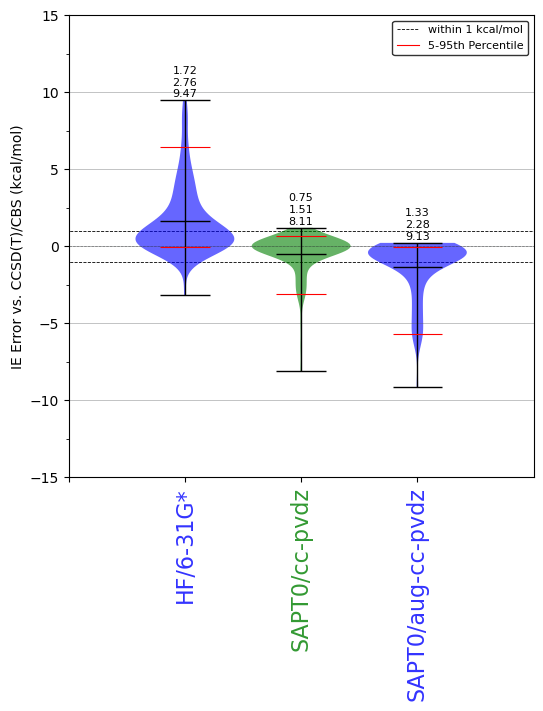

In [20]:
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        # "svwn/6-31G*": "svwn/6-31G* error",
        # "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
    },
    output_filename="S22-IE.png",
    figure_size=(6, 6),
    x_label_fontsize=16,
    ylim=(-15, 15),
    rcParams={},
    usetex=False,
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)
plt.show()

![S22-IE_violin.png](./S22-IE_violin.png)

# QCMLForge
The previous sections conclude the benchmarking workflow; however, the remaining blocks in this
notebook focus on using this QM data to train models and run inference to compare against QM methods. 

## Interaction energy ML model inference
A specialized atom-pairwise neural network
([AP-Net](https://pubs.rsc.org/en/content/articlehtml/2024/sc/d4sc01029a))
architecture developed in the Sherrill group has been trained on 1.6 million
dimers to predict SAPT0/aug-cc-pV(D+d)Z interaction energies. The model has been
re-implemented and re-trained in PyTorch in QCMLForge for extending in the
future. Below will take a pre-trained AP-Net2 model and predict energies on our
current dimer dataset.  Note that the AP-Net2 architecture relies on first an
AtomModel for predicting multipoles and intramolecular features, prior to more
message passing neural networks for predicting SAPT component energies. As such,
we must load pre-trained AtomModel weights and APNet2Model weights.

In [21]:
import apnet_pt
from apnet_pt.AtomPairwiseModels.apnet2 import APNet2Model
from apnet_pt.AtomModels.ap2_atom_model import AtomModel

atom_model = AtomModel().set_pretrained_model(model_id=0)
ap2 = APNet2Model(atom_model=atom_model.model).set_pretrained_model(model_id=0)
ap2.atom_model = atom_model.model
print(df_plot['qcel_molecule'].tolist())
apnet2_ies_predicted = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=16
)

running on the CPU
running on the CPU
self.dataset=None
[Molecule(name='C2H4O4', formula='C2H4O4', hash='c5abb54'), Molecule(name='CH7NO', formula='CH7NO', hash='5ec955b'), Molecule(name='C3H9NO2', formula='C3H9NO2', hash='8682f32'), Molecule(name='C6H8O', formula='C6H8O', hash='eaedeb0'), Molecule(name='C4H8O4', formula='C4H8O4', hash='35b6c18'), Molecule(name='C4H8O4', formula='C4H8O4', hash='85f67af'), Molecule(name='H4O2', formula='H4O2', hash='80c4390'), Molecule(name='C2H6N2O2', formula='C2H6N2O2', hash='084885d'), Molecule(name='C3H9NO2', formula='C3H9NO2', hash='b28b356'), Molecule(name='C2H4O4', formula='C2H4O4', hash='f55cc2e'), Molecule(name='CH7NO', formula='CH7NO', hash='682fa43'), Molecule(name='FH2O', formula='FH2O-', hash='d69cf34'), Molecule(name='C2H10N2', formula='C2H10N2', hash='9f0ed39'), Molecule(name='C6H8O', formula='C6H8O', hash='849097c'), Molecule(name='C2H4O4', formula='C2H4O4', hash='55b0ef0'), Molecule(name='C3H9NO2', formula='C3H9NO2', hash='72f9061'), Mo

Plotting S22-IE-AP2.png
S22-IE-AP2_violin.png


<Figure size 3840x2880 with 0 Axes>

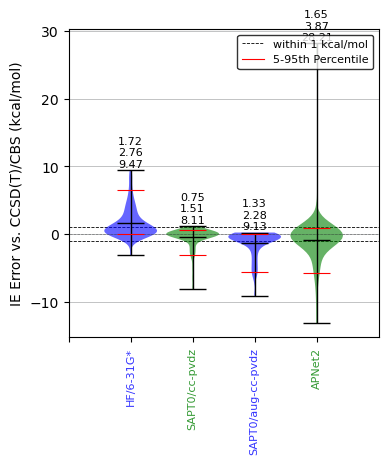

In [22]:
# AP-Net2 IE
df_plot['APNet2'] = np.sum(apnet2_ies_predicted, axis=1)
df_plot['APNet2 error'] = (df_plot['APNet2'] - df_plot['reference']).astype(float)
#print(df_plot.sort_values(by='APNet2 error', ascending=True)[['APNet2', 'reference']])
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        # "svwn/6-31G*": "svwn/6-31G* error",
        # "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
    },
    output_filename="S22-IE-AP2.png",
    rcParams={},
    usetex=False,
    figure_size=(4, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)
plt.show()

![S22-IE-AP2_violin.png](./S22-IE-AP2_violin.png)

# Transfer Learning
To demonstrate transfer learning, we can use our reference data to then tune our
pre-trained SAPT0 model to predict the CCSD(T)/CBS energies. Then we will
re-plot, evaluating the model performance. Note that in any application, you
should certainly use much more data and careful train/test set selection than
what is done in this notebook. This is purely meant for demonstraion purposes
only.

In [23]:
# Training models on new QM data: Transfer Learning

from apnet_pt import pairwise_datasets

ds2 = pairwise_datasets.apnet2_module_dataset(
    root="data_dir",
    spec_type=None,
    atom_model=atom_model,
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=[np.array([i]) for i in df_plot['reference'].tolist()],
    skip_compile=True,
    force_reprocess=True,
    atomic_batch_size=8,
    prebatched=False,
    in_memory=True,
    batch_size=4,
)
print(ds2)

Received 100 QCElemental molecules with energy labels
Processing directly from provided QCElemental molecules...
Processing 100 dimers from provided QCElemental molecules...
Creating data objects...
len(RAs)=100, self.atomic_batch_size=8, self.batch_size=4
0/100, 0.02s, 0.02s
8/100, 0.02s, 0.05s
16/100, 0.02s, 0.07s
24/100, 0.02s, 0.09s
32/100, 0.02s, 0.11s


Processing...


40/100, 0.02s, 0.13s
48/100, 0.03s, 0.16s
56/100, 0.02s, 0.17s
64/100, 0.02s, 0.19s
72/100, 0.02s, 0.21s
80/100, 0.02s, 0.23s
88/100, 0.02s, 0.25s
96/100, 0.01s, 0.27s
Processing directly from provided QCElemental molecules...


Done!
Processing...


Processing 100 dimers from provided QCElemental molecules...
Creating data objects...
len(RAs)=100, self.atomic_batch_size=8, self.batch_size=4
0/100, 0.03s, 0.03s
8/100, 0.03s, 0.05s
16/100, 0.03s, 0.08s
24/100, 0.02s, 0.11s
32/100, 0.02s, 0.13s
40/100, 0.02s, 0.15s
48/100, 0.02s, 0.17s
56/100, 0.02s, 0.19s
64/100, 0.02s, 0.22s
72/100, 0.03s, 0.24s
80/100, 0.02s, 0.26s
88/100, 0.02s, 0.29s
96/100, 0.01s, 0.30s
self.root='data_dir', self.spec_type=None, self.in_memory=True
apnet2_module_dataset(100)


Done!


In [24]:
# Transfer Learning APNet2 model on computed QM data
ap2.train(
    dataset=ds2,
    n_epochs=50,
    transfer_learning=True,
    skip_compile=True,
    model_path="apnet2_transfer_learning.pt",
    split_percent=0.8,
)

Saving training results to...
apnet2_transfer_learning.pt
~~ Training APNet2Model ~~
    Training on 80 samples, Testing on 20 samples

Network Hyperparameters:
  self.model.n_message=3
  self.model.n_neuron=128
  self.model.n_embed=8
  self.model.n_rbf=8
  self.model.r_cut=5.0
  self.model.r_cut_im=8.0

Training Hyperparameters:
  n_epochs=50
  lr=0.0005

  lr_decay=None

  batch_size=4
Running single-process training
                                       Total
  (Pre-training) (0.64   s)  MAE:   1.525/2.130  
  EPOCH:    0 (0.74   s)  MAE:   2.223/2.910    
  EPOCH:    1 (0.75   s)  MAE:   1.098/2.808    
  EPOCH:    2 (0.75   s)  MAE:   1.073/2.761    
  EPOCH:    3 (0.78   s)  MAE:   0.772/2.535    
  EPOCH:    4 (0.77   s)  MAE:   0.524/2.327    
  EPOCH:    5 (0.77   s)  MAE:   0.435/2.608    
  EPOCH:    6 (0.77   s)  MAE:   0.519/2.317    
  EPOCH:    7 (0.75   s)  MAE:   0.457/2.436    
  EPOCH:    8 (0.79   s)  MAE:   0.427/2.309    
  EPOCH:    9 (0.76   s)  MAE:   0.319/2.

Plotting S22-IE-AP2-tf.png
S22-IE-AP2-tf_violin.png


<Figure size 3840x2880 with 0 Axes>

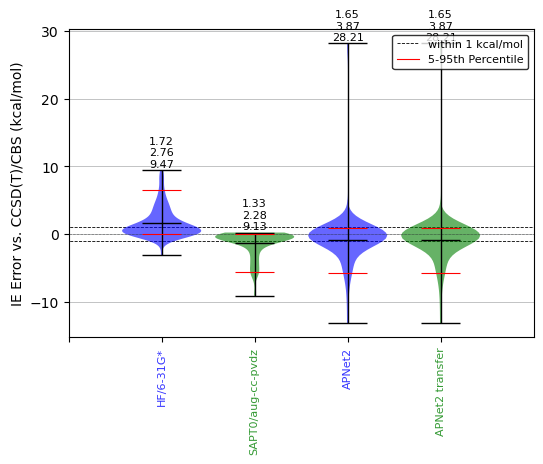

In [25]:
# AP-Net2 IE
apnet2_ies_predicted_transfer = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=16,
)
df_plot['APNet2 transfer'] = np.sum(apnet2_ies_predicted_transfer, axis=1)
df_plot['APNet2 transfer error'] = (df_plot['APNet2 transfer'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        # "svwn/6-31G*": "svwn/6-31G* error",
        # "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
        "APNet2 transfer": "APNet2 transfer error",
    },
    output_filename="S22-IE-AP2-tf.png",
    rcParams={},
    usetex=False,
    figure_size=(6, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)
plt.show()

![S22-IE_violin-AP2-tf.png](./S22-IE-AP2-tf_violin.png)

## $\Delta$ Models
Another option available in QCMLForge is to train $\Delta {\rm APNet2}$ models 
to predict the difference between one level of theory and another. This
example highlights learning how to go from our computed HF/6-31G* IEs
to our CCSD(T)/CBS energies.

In [26]:
from apnet_pt.pt_datasets.dapnet_ds import dapnet2_module_dataset_apnetStored

delta_energies = df_plot['HF/6-31G* error'].tolist()

# Only operates in pre-batched mode
ds_dap2 = dapnet2_module_dataset_apnetStored(
    root="data_dir",
    r_cut=5.0,
    r_cut_im=8.0,
    spec_type=None,
    max_size=None,
    force_reprocess=True,
    batch_size=2,
    num_devices=1,
    skip_processed=False,
    skip_compile=True,
    print_level=2,
    in_memory=True,
    m1="HF/6-31G*",
    m2="CCSD(T)/CBS",
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=delta_energies,
)
print(ds_dap2)

Received 100 QCElemental molecules with energy labels
running on the CPU
running on the CPU
Loading pre-trained APNet2_MPNN model from /home/amwalla3/miniconda3/envs/p4_qcml/lib/python3.10/site-packages/apnet_pt/models/ap2_ensemble/ap2_0.pt
self.dataset=None
raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Creating data objects...
len(qcel_mols)=100, self.batch_size=2


Processing...
Done!
Processing...


raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Creating data objects...
len(qcel_mols)=100, self.batch_size=2
self.root='data_dir', self.spec_type=None, self.in_memory=True
raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Saving to data_dir/processed_delta/targets_HF6-31G_to_CCSD_LP_T_RP_CBS.pt
dapnet2_module_dataset_apnetStored(50)


Done!


In [27]:
from apnet_pt.AtomPairwiseModels.dapnet2 import dAPNet2Model

dap2 = dAPNet2Model(
    atom_model=AtomModel().set_pretrained_model(model_id=0),
    apnet2_model=APNet2Model().set_pretrained_model(model_id=0).set_return_hidden_states(True),
)
dap2.train(
    ds_dap2,
    n_epochs=50,
    skip_compile=True,
    split_percent=0.6,
)

running on the CPU
running on the CPU
self.dataset=None
running on the CPU
None
Saving training results to...
None
~~ Training APNet2Model ~~
    Training on 30 samples, Testing on 20 samples

Network Hyperparameters:
  self.model.n_neuron=128

Training Hyperparameters:
  n_epochs=50
  lr=0.0005

  lr_decay=None

  batch_size=1
Running single-process training
num_workers = 4
                                       Energy
  (Pre-training) (0.23   s)  MAE:   1.831/1.649  
  EPOCH:    0 (0.25   s)  MAE:   1.152/0.980   *
  EPOCH:    1 (0.26   s)  MAE:   0.996/0.830   *
  EPOCH:    2 (0.26   s)  MAE:   0.750/0.897   *
  EPOCH:    3 (0.27   s)  MAE:   0.687/0.820   *
  EPOCH:    4 (0.25   s)  MAE:   0.617/0.970    
  EPOCH:    5 (0.25   s)  MAE:   0.616/0.725   *
  EPOCH:    6 (0.26   s)  MAE:   0.582/0.763   *
  EPOCH:    7 (0.26   s)  MAE:   0.556/0.770    
  EPOCH:    8 (0.26   s)  MAE:   0.500/0.755   *
  EPOCH:    9 (0.26   s)  MAE:   0.524/0.629   *
  EPOCH:   10 (0.26   s)  MAE:   0.5

            dAPNet2 HF/6-31G* HF/6-31G*-dAPNet2  reference
entry                                                     
LoS-IE-0   2.805237 -15.29702        -18.102256    -18.075
LoS-IE-1   0.482784 -4.790555         -5.273339     -5.220
LoS-IE-2   1.119751     -3.52         -4.639751     -4.700
LoS-IE-3   0.225899 -0.441187         -0.667086     -0.420
LoS-IE-4   0.443690 -8.814418         -9.258107     -9.210
...             ...       ...               ...        ...
LoS-IE-95  0.622295 -4.834655          -5.45695     -5.532
LoS-IE-96  7.804511 -4.583762        -12.388272    -12.862
LoS-IE-97  0.446845 -3.208742         -3.655587     -3.350
LoS-IE-98 -0.079373  -3.78051         -3.701137     -3.590
LoS-IE-99  0.181476 -0.542195         -0.723671     -0.620

[100 rows x 4 columns]
Plotting S22-IE-AP2-dAP2.png
S22-IE-AP2-dAP2_violin.png


<Figure size 3840x2880 with 0 Axes>

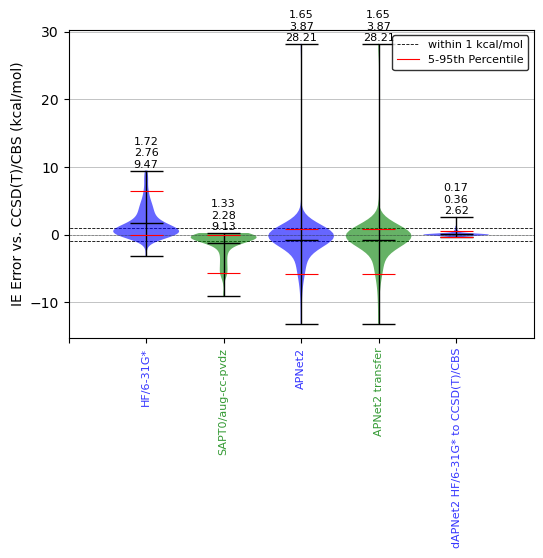

In [28]:
dAPNet2_ies_predicted_transfer = dap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=2,
)
df_plot['dAPNet2'] = dAPNet2_ies_predicted_transfer
df_plot['HF/6-31G*-dAPNet2'] = df_plot['HF/6-31G*'] - df_plot['dAPNet2']
print(df_plot[['dAPNet2', 'HF/6-31G*', 'HF/6-31G*-dAPNet2',  'reference']])
df_plot['dAPNet2 error'] = (df_plot['HF/6-31G*-dAPNet2'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        # "svwn/6-31G*": "svwn/6-31G* error",
        # "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
        "APNet2 transfer": "APNet2 transfer error",
        "dAPNet2 HF/6-31G* to CCSD(T)/CBS": "dAPNet2 error",
    },
    output_filename="S22-IE-AP2-dAP2.png",
    rcParams={},
    usetex=False,
    figure_size=(6, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)
plt.show()

In [ ]:
# Be careful with this for it can corrupt running status...
# !ps aux | grep qcfractal | awk '{ print $2 }' | xargs kill -9

![S22-IE_violin-AP2-dAP2.png](./S22-IE-AP2-dAP2_violin.png)

# The end...

This notebook has been designed to help demonstrate how QCArchive can be used to
compute QM properties through cybershuttle, and then leverage that data for
analysis or training AP-Net based models through QCMLForge. 

If you have any questions about this notebook or used packages, please feel
free to reach out to me at awallace43@gatech.edu!